In [1]:
# importing libraries

import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [2]:
df = pd.read_csv("heart_2020_cleaned.csv")

df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [3]:
# Changing values to be suitable for our model

df["HeartDisease"] = df["HeartDisease"].replace(["No", "Yes"], [0, 1])
df["Smoking"] = df["Smoking"].replace(["No", "Yes"], [0, 1])
df["AlcoholDrinking"] = df["AlcoholDrinking"].replace(["No", "Yes"], [0, 1])
df["Stroke"] = df["Stroke"].replace(["No", "Yes"], [0, 1])
df["DiffWalking"] = df["DiffWalking"].replace(["No", "Yes"], [0, 1])
df["PhysicalActivity"] = df["PhysicalActivity"].replace(["No", "Yes"], [0, 1])
df["Asthma"] = df["Asthma"].replace(["No", "Yes"], [0, 1])
df["KidneyDisease"] = df["KidneyDisease"].replace(["No", "Yes"], [0, 1])
df["SkinCancer"] = df["SkinCancer"].replace(["No", "Yes"], [0, 1])
df["Diabetic"] = df["Diabetic"].replace(["No", "No, borderline diabetes", "Yes", "Yes (during pregnancy)"], [0, 0, 1, 1])

df["Sex"] = df["Sex"].replace(["Female", "Male"], [0, 1])
races = ["Other", "White", "American Indian/Alaskan Native", "Hispanic", "Asian", "Black"]
races_as_numbers = [0, 0.2, 0.4, 0.6, 0.8, 1]
df["Race"] = df["Race"].replace(races, races_as_numbers)
general_health_markers = ["Poor", "Fair", "Excellent", "Good", "Very good"]
general_health_markers_as_numbers = [0, 0.25, 0.5, 0.75, 1]
df["GenHealth"] = df["GenHealth"].replace(general_health_markers, general_health_markers_as_numbers)
age_categories = list(df["AgeCategory"].value_counts().index)
age_categories.sort()
len_age_categories = len(age_categories)
# The list below will end up having values from 0 to 1, with the same distance between each other
age_categories_as_numbers = [(1 / (len_age_categories - 1)) * idx for idx in range(len_age_categories)]
df["AgeCategory"] = df["AgeCategory"].replace(age_categories, age_categories_as_numbers)

df["BMI"] = df["BMI"].astype("int")

<AxesSubplot:>

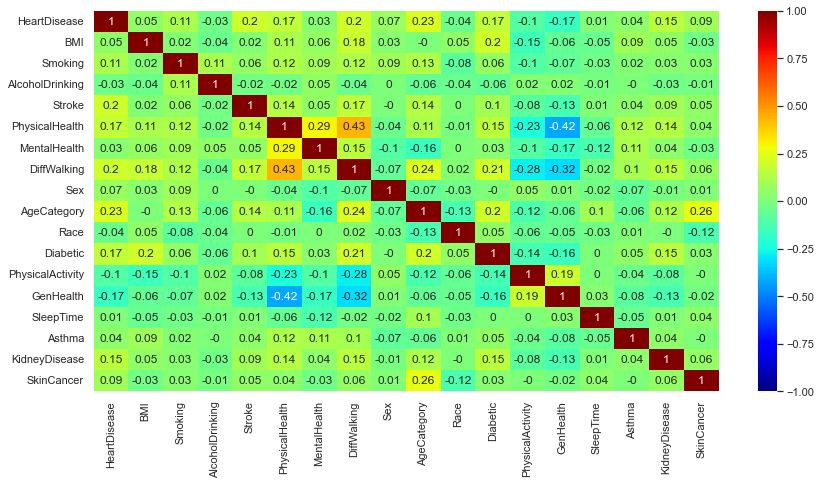

In [4]:
# Seeing which features correlate with "HeartDisease" the most(first column)
# These will be used in our machine learning model, while the others will be discarded

sns.set(rc = {'figure.figsize':(14,7)})
sns.heatmap(df.corr().round(2), annot=True, cmap='jet', vmin=-1, vmax=1)

In [5]:
# Since we want the model to be really good at finding positive cases, the most important metric for it will be recall, followed closely by precision
# First we will check how many features we can add to our model to get the best recall and precision

def compute_decisiontreeclassifier_metrics(X_train, X_test, y_train, y_test, repetions=10):
    acc = 0
    prec = 0
    recall = 0
    f1 = 0
    for _ in range(repetions):
        model = DecisionTreeClassifier()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc += metrics.accuracy_score(y_test, y_pred)
        # There can be 0 positive predictions, so we set zero_divison=0 to avoid any errors
        prec += metrics.precision_score(y_test, y_pred, zero_division = 0)
        recall += metrics.recall_score(y_test, y_pred)
        f1 += metrics.f1_score(y_test, y_pred)
    
    acc /= repetions
    prec /= repetions
    recall /= repetions
    f1 /= repetions
    
    return acc, prec, recall, f1

# Stores the correlation between every feature and HeartDisease (first column from our heatmap) in descending order of absolute value
corr_to_heartdisease = pd.Series(df.corr().round(2).iloc[:,0]).drop("HeartDisease").abs()
corr_to_heartdisease = corr_to_heartdisease.sort_values(ascending=False)

X = pd.DataFrame()
y = df["HeartDisease"]
result = pd.DataFrame(columns=["acc", "prec", "recall", "f1"])
for index in corr_to_heartdisease.index:
    X[index] = df[index]
    print(f"Iteration {len(X.columns)}/{len(corr_to_heartdisease.index)}")

    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)
    
    scores = compute_decisiontreeclassifier_metrics(X_train, X_test, y_train, y_test)
    
    row_name = ""
    for column in X.columns:
        row_name += column[:3] + ","
    row_name = row_name[:-1]
    
    result.loc[row_name] = scores

print(result)
# recall seems to rise with the number of features, so the best recall is with all 17 features(aprox. 0.25)
# precision seems to decrease with the number of features, starting at 4 features(starts at aprox. 0.5 and ends up at 0.25)
# because the f1 score is at it's highest with all 17 features(aprox. 0.25), we will use all of them for our model

Iteration 1/17
Iteration 2/17
Iteration 3/17
Iteration 4/17
Iteration 5/17
Iteration 6/17
Iteration 7/17
Iteration 8/17
Iteration 9/17
Iteration 10/17
Iteration 11/17
Iteration 12/17
Iteration 13/17
Iteration 14/17
Iteration 15/17
Iteration 16/17
Iteration 17/17
                                                         acc      prec  \
Age                                                 0.914007  0.000000   
Age,Str                                             0.914852  0.000000   
Age,Str,Dif                                         0.914476  0.000000   
Age,Str,Dif,Dia                                     0.913398  0.516556   
Age,Str,Dif,Dia,Phy                                 0.913588  0.492654   
Age,Str,Dif,Dia,Phy,Gen                             0.912614  0.451255   
Age,Str,Dif,Dia,Phy,Gen,Kid                         0.913701  0.452380   
Age,Str,Dif,Dia,Phy,Gen,Kid,Smo                     0.911773  0.434215   
Age,Str,Dif,Dia,Phy,Gen,Kid,Smo,Phy                 0.906923  0.372242 